# Optical STEM optimization
---
**Author**: Arent Kievits

**Date**: 09-07-2023

### **Overview**
- Calculate signal-to-noise ratio (SNR) for different landing energies and dwell times
- Plot images and SNR as a function of dwell time and landing energy (keV) 

### **Data**
LE (keV) | Dwell time (ns) | Pixel size (nm/px) |
- | - | - 
2.5<br>3.0<br>3.5<br>4.0<br>4.5<br>5.0<br>5.5<br>6.0<br>6.5<br>7.0<br>7.5<br>8.0 | 0<br>100<br>200<br>500<br>1000<br>1500<br>2000<br>3000 | 1 


In [1]:
%config Completer.use_jedi = False
# Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
    
import numpy as np
import ssnr
import matplotlib.pyplot as plt
import altair as alt
from pathlib import Path
from skimage import img_as_float, img_as_uint
from skimage.util import crop
from skimage import exposure
import tifffile as tf
import pandas as pd
import re
import seaborn as sns
from tqdm.notebook import tqdm

## 1. Load image data
---


In [3]:
# Find directory
DATA_dir = Path("../data/2_Optimization-OSTEM/Optimization_OSTEM/")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('*/*/*.tif'))})

# Build up DataFrame
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im['Dwell'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# Preview
df_im.sort_values(['LE','Dwell'], inplace=True)
df_im.sample(5)

,FilePos,LE,Dwell
250,..\data\2_Optimization-OSTEM\Optimization_OSTE...,6,100
217,..\data\2_Optimization-OSTEM\Optimization_OSTE...,6.5,100
99,..\data\2_Optimization-OSTEM\Optimization_OSTE...,4.5,100
69,..\data\2_Optimization-OSTEM\Optimization_OSTE...,3,100
255,..\data\2_Optimization-OSTEM\Optimization_OSTE...,6,200


## 2. Perform SSNR measurements
---

In [11]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['LE', 'Dwell', 'SSNR', 'SNR_Joy'])

# Loop through bioimages
for i, row in df_im.iterrows():

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    crop_width = (((image.shape[0] - 700) // 2,) * 2,
                  ((image.shape[1] - 1536) // 2,) * 2)
    cropped = crop(image, crop_width=crop_width, copy=True)

    # Compute SNR from SSNR
    images = ssnr.split_image(cropped)
    snr = ssnr.SSNR_full(images)
    
    # Computer SNR by Joy, 2003
    snr_joy = ssnr.SNR_JOY(cropped)

    # Populate DataFrame
    df_snr.loc[i, 'LE'] = row['LE']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR'] = snr
    df_snr.loc[i, 'SNR_Joy'] = snr_joy # Joy method taken as standard

# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('LE')\
      .apply(lambda x: x[::len(df_snr)//10])

,,LE,Dwell,SSNR,SNR_Joy
LE,,,,,
2.5,5,2.5,100,0.516706,0.017238
3,65,3,100,0.875121,0.204820
3.5,35,3.5,100,0.693007,0.081200
4,125,4,100,0.907666,0.235370
4.5,95,4.5,100,0.645776,0.120334
5,186,5,100,0.553952,0.061729
5.5,155,5.5,100,0.534816,0.030584
6,247,6,100,0.490555,0.030790
6.5,216,6.5,100,0.499655,0.035900


In [12]:
df_snr = df_snr.sort_values(['LE','Dwell'], ascending=[True,True])
df_snr['Dwell'] = df_snr['Dwell'].astype(int)

## 3. Plot optimization results (SSNR vs Joy) for different LE and dwell time
---

In [13]:
# Filter data to only include longest dwell times
source = df_snr.loc[(df_snr['Dwell'].isin([1000, 3000])) &\
                   (df_snr['SSNR'] > 0.001)]\
               .reset_index()\
               .copy()
source.sample(5)

,index,LE,Dwell,SSNR,SNR_Joy
25,45,3.5,3000,0.640825,0.586559
113,334,8,1000,0.220779,0.042862
114,335,8,1000,0.269552,0.058008
106,288,7.5,3000,0.427317,0.088965
23,33,3.5,1000,0.719065,0.524782


In [14]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from matplotlib import cycler
import matplotlib as mpl

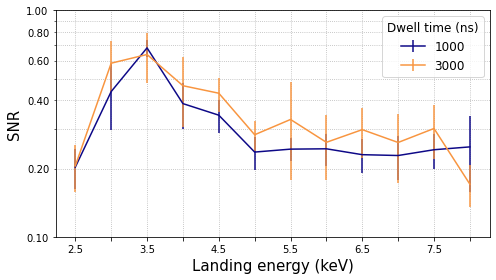

In [15]:
# Make figure
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 0.75, 2)))
fig, ax = plt.subplots(figsize=(7, 4))
legend = []
fs=15

# Group by dwell time
for dwell, images in source.groupby(by=['Dwell']):
    
    # Calculate mean and std of SSNR
    mean = images.groupby(by=['LE'])['SSNR'].mean()
    std = images.groupby(by=['LE'])['SSNR'].std()
    
    # Plot 
    ax.errorbar(images.LE.unique(), mean, yerr=std)
    legend.append(dwell)
    
# Axis aesthetics
ax.set_yscale('log')
ax.set_ylim([1e-1, 1])
ax.grid(which='both', ls=':') 
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.grid(which='both', ls=':') 
ax.legend(legend, title='Dwell time (ns)', fontsize=fs-3, title_fontsize=fs-3)
ax.set_xlabel('Landing energy (keV)',fontsize=fs)
ax.set_ylabel('SNR', fontsize=fs)

# Tidy up axes
for label in ax.yaxis.get_minorticklabels()[1::2]:
    label.set_visible(False) 
for label in ax.xaxis.get_majorticklabels()[1::2]:
    label.set_visible(False)
plt.tight_layout()
plt.savefig('SSNR_optimization', dpi=300)

## Spectral SNR

In [501]:
# source = df_snr.copy()
scheme = 'viridis'

chart = alt.Chart().encode(
    x=alt.X('kV:Q',
            axis=alt.Axis(tickMinStep=0.5,
                          title='Landing energy [keV]')),
    y=alt.Y('SSNR:Q',
            aggregate='mean',
            scale=alt.Scale(domain=[0.1,1], type='log',)),
    color=alt.Color('Dwell time (ns):N',
                    scale=alt.Scale(scheme=scheme))
).properties(width=720,
             height=375)

chart = (chart.mark_line() +\
         chart.mark_point(size=20))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('kV:Q'),
    y=alt.Y('SSNR:Q'),
    color=alt.Color('Dwell time (ns):N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=24,
    titleFontSize=24,
    
).configure_legend(
    titleFontSize=23,
    labelFontSize=23,
    orient='bottom'
) 

alt.LayerChart(...)

## SNR (Joy 2002)

In [47]:
# Data source for plot
df_filtered = df_snr.loc[df_snr['Dwell time (ns)'] > 500]
source = df_filtered.loc[df_filtered['SNR (Joy)'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('kV:Q',
            axis=alt.Axis(tickMinStep=0.5,
                          title='Landing energy [keV]')),
    y=alt.Y('SNR (Joy)',
            title='SNR',
            aggregate='mean',
            scale=alt.Scale(domain=[0.01, 1], 
                            type='log')),
    color=alt.Color('Dwell time (ns):N',
                    scale=alt.Scale(scheme=scheme))
).properties(width=500,
             height=250)

chart = (chart.mark_line() +\
         chart.mark_point(size=20))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('kV:Q'),
    y=alt.Y('SNR (Joy):Q'),
    color=alt.Color('Dwell time (ns):N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=18,
    titleFontSize=18,
    
).configure_legend(
    titleFontSize=15,
    labelFontSize=15,
    orient='bottom'
) 

alt.LayerChart(...)

## 4. Plot series of images with different landing energy 
---


In [17]:
from matplotlib_scalebar.scalebar import ScaleBar

### 4.1 Import selected images

In [6]:
# Find directory
DATA_dir = Path("../data/2_Optimization-OSTEM/Qualitative/")

# Select files and initialize DataFrame with image locations
df_im_qual = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_im_qual['kV'] = df_im_qual['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im_qual['Dwell time (ns)'] = df_im_qual['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# Preview
df_im_qual.sort_values(['kV','Dwell time (ns)'], inplace=True)
df_im_qual['kV'] =df_im_qual['kV'].astype(float)
df_im_qual.sample(5)

,FilePos,kV,Dwell time (ns)
7,..\data\2_Optimization-OSTEM\Qualitative\OSTEM_6.5kV_3000ns_003.tif,6.5,3000
0,..\data\2_Optimization-OSTEM\Qualitative\OSTEM_2.5kV_3000ns_002.tif,2.5,3000
5,..\data\2_Optimization-OSTEM\Qualitative\OSTEM_5.5kV_3000ns_004.tif,5.5,3000
8,..\data\2_Optimization-OSTEM\Qualitative\OSTEM_6kV_3000ns_003.tif,6.0,3000
3,..\data\2_Optimization-OSTEM\Qualitative\OSTEM_4.5kV_3000ns_003.tif,4.5,3000


### 4.2 Plot images

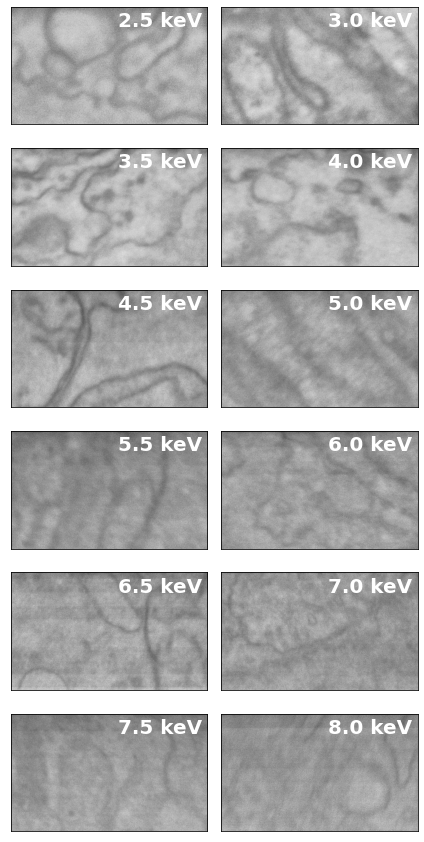

In [9]:
# Set the dwell time
DT = 3000 # ns
df_im_qual['Dwell time (ns)'] = df_im_qual['Dwell time (ns)'].astype(int)
source = df_im_qual
source = source.sort_values(['kV'], ascending=[True])
title = 'Landing energy optimization'

# Make figure
ncols = 2
nrows = int(source['kV'].unique().size / ncols)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(3*ncols, 2*nrows))
plt.subplots_adjust(hspace=0.00)
plt.subplots_adjust(wspace=0.00)
axmap = {k: v for k, v in zip(source['kV'].unique(), axes.flat)}

# Iterate through subsets of inidivual values for kV
for KV, grp in source.groupby('kV'):

    # Set axis
    ax = axmap[KV]
    
    # Add scalebar for first image
    # if KV == 2.5:
    #     scalebar = ScaleBar(0.001, "um", length_fraction=0.4, font_properties={"size": 10, "weight": "bold"},
    #                         location='lower left')
    #     ax.add_artist(scalebar)
    
    # Choose one image per subset (landing energy) to plot
    for i, row in grp.groupby('kV').apply(lambda x: x.sample(1)).iterrows():
        im = img_as_float(tf.imread(row['FilePos'].as_posix()))
        cropped = im[:920,:1536]
        cropped_norm = ((cropped - cropped.min()) / (cropped.max() - cropped.min()))*65565
        image = ax.imshow(cropped_norm, cmap='Greys_r')
        # ax.imshow(cropped, cmap='Greys_r')

    # Axis aesthetics
    title = f"{KV} keV"
    ax.set_title(title, x=0.76, y=0.78, c='white', fontsize=20, fontweight="bold")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# cbar_ax = fig.add_axes([0.02, 0.64, 0.02, 0.18])
# cbar = fig.colorbar(image, cax=cbar_ax)
plt.tight_layout()
plt.savefig('Optimization', dpi=300)

### 4.3 Plot corresponding histograms

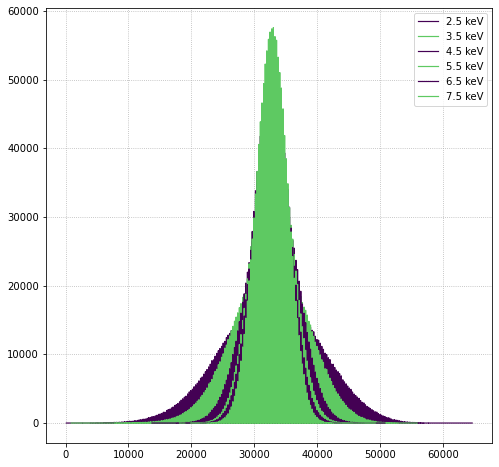

In [285]:
# Make figure (kV varies by col)
ncols = 2
nbins = 1024
legend = []

fig, ax = plt.subplots(figsize=(8,8))
    
# Choose one image per subset (landing energy) to plot
for i, row in df_im_qual.groupby('Dwell time (ns)').apply(lambda x: x[::2]).iterrows():
    im = img_as_uint(tf.imread(row['FilePos'].as_posix()))
    cropped = im[:920,:1536]
        
    # Center intensity distribution (for 16-bit give it median 32767)
    median_int = np.median(cropped)
    cropped_centered = cropped - median_int + 32767
    cropped_centered = np.uint16(cropped_centered)
        
    # Plot
    hist, bin_centers = exposure.histogram(cropped_centered, nbins=nbins, source_range='dtype')
    
    elements = np.nonzero(hist)
    bound1, bound2 = elements[0][0], elements[0][-1]
    ax.plot(bin_centers[bound1:bound2], hist[bound1:bound2], linewidth=1.2)
    #ax.fill_between(bin_centers[bound1:bound2], 0, hist[bound1:bound2], alpha=0.1)

    # Axis aesthetics
    # title = f"{KV} keV"
    # ax.set_title(title, fontsize=15)
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.grid(ls=':')  
    legend = legend + [f"{row['kV']} keV"]
    
ax.legend(legend)
# plt.savefig('Optimization', dpi=300)

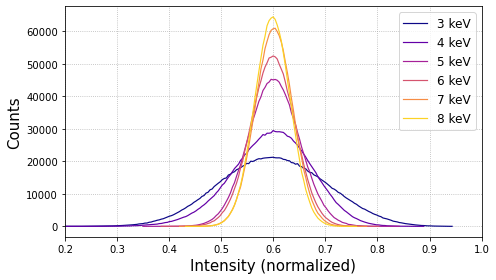

In [332]:
# Data
source=df_im_qual.copy()

# Make figure
ncols = 2
nbins = 512
legend = []
fs=15

fig, ax = plt.subplots(figsize=(7,4))

# Colours
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 2, len(source['kV'].unique()))))
    
# Choose one image per subset (landing energy) to plot
for i, row in df_im_qual.groupby('Dwell time (ns)').apply(lambda x: x[1::2]).iterrows():
    im = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = im[:920,:1536]
        
    # Center intensity distribution (for 16-bit give it median 32767)
    median_int = np.median(cropped)
    cropped_centered = 0.6 + cropped - median_int 
    # Plot 
    hist, bin_centers = exposure.histogram(cropped_centered, nbins=nbins, source_range='dtype')
    
    # Find first and last non-zero element
    elements = np.nonzero(hist)
    bound1, bound2 = elements[0][0], elements[0][-1]
    ax.plot(bin_centers[bound1:bound2], hist[bound1:bound2], linewidth=1.2)
    ax.grid(ls=':')  
    legend = legend + [f"{row['kV']} keV"]
    
ax.legend(legend, fontsize=fs-3)
ax.set_xlim([0.2, 1])
ax.set_xlabel('Intensity (normalized)',fontsize=fs)
ax.set_ylabel('Counts',fontsize=fs)
plt.tight_layout()
plt.savefig('Contrast drop', dpi=300)

## 1. Load image data from previous experiments
---


In [13]:
# Find directory
DATA_dir = Path("../sb_optical_STEM/Optimization_OSTEM_WZ")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('*/*.tif'))})

# Build up DataFrame
df_im['kV'] = df_im['FilePos'].apply(lambda x: x.name.split(' ')[1].split('kev')[0])
df_im['Dwell time (ns)'] = '5000'

# Preview
df_im.sort_values(['kV','Dwell time (ns)'], inplace=True)
df_im.sample(5)

ValueError: a must be greater than 0 unless no samples are taken

## 2. Perform SSNR measurements
---

In [47]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['kV', 'Dwell time (ns)', 'SNR (SSNR)', 'SNR (Joy)'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), 
                   total=len(df_snr)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    crop_width = (((image.shape[0] - 2048) // 2,) * 2,
                  ((image.shape[1] - 3072) // 2,) * 2)
    cropped = crop(image, crop_width=crop_width, copy=True)

    # Compute SNR from SSNR
    images = ssnr.split_image(cropped)
    snr = ssnr.SSNR_full(images)
    
    # Computer SNR by Joy, 2003
    snr_joy = ssnr.SNR_JOY(cropped)

    # Populate DataFrame
    df_snr.loc[i, 'kV'] = row['kV']
    df_snr.loc[i, 'Dwell time (ns)'] = row['Dwell time (ns)']
    df_snr.loc[i, 'SNR (SSNR)'] = snr
    df_snr.loc[i, 'SNR (Joy)'] = snr_joy

# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('kV')\
      .apply(lambda x: x[::len(df_snr)//10])

0it [00:00, ?it/s]

kV Dwell time (ns)  SNR (SSNR)  SNR (Joy)
kV                                                  
10.0 0   10.0  5000            3.066064    2.976801 
11.0 5   11.0  5000            1.733437    1.661397 
2.5  8   2.5   5000            0.296873    0.256457 
3.0  12  3.0   5000            0.467884    0.431646 
3.5  18  3.5   5000            1.708477    1.675350 
     26  3.5   5000            0.961522    0.920066 
     34  3.5   5000            1.146477    1.095108 
4.0  38  4.0   5000            2.838901    2.747861 
     46  4.0   5000            3.098080    3.058146 
4.5  50  4.5   5000            4.336887    4.301317 
     58  4.5   5000            3.178423    3.125169 
5.0  59  5.0   5000            3.668115    3.576563 
6.0  66  6.0   5000            2.583256    2.502149 
7.0  73  7.0   5000            4.384500    4.251383 
8.0  79  8.0   5000            2.785976    2.692700 
9.0  82  9.0   5000            2.238836    2.161554

In [48]:
# Convert str values to float
df_snr['Dwell time (ns)'] = df_snr['Dwell time (ns)'].astype(float)

df_snr['Title'] = 'SSNR as a function of landing energy and dwell time'
df_snr = df_snr.rename(columns={"Landing energy [kV]": "Landing energy [keV]"})

In [49]:
df_snr['SNR1'] = 'SNR (SSNR)'
df_snr['SNR2'] = 'SNR (Joy)'

## 3. Plot optimization results (SSNR vs Joy) for different kV and dwell time
---

## Spectral SNR

## SNR (Joy 2002) and SNR from SSNR

In [51]:
# Data source for plot
source = df_snr.loc[df_snr['SNR (Joy)'] > 0.001].copy()
source = df_snr.loc[df_snr['SNR (SSNR)'] > 0.001].copy()
scheme = 'category10'


chart1 = alt.Chart(source).encode(
    x=alt.X('kV:Q',
            axis=alt.Axis(tickMinStep=0.5,
                          title='Landing energy [keV]')),
    y=alt.Y('SNR (Joy):Q',
            aggregate='mean',
            scale=alt.Scale(domain=[0, 5])),
    color=alt.Color('SNR2:N',
                    scale=alt.Scale(scheme=scheme))
).properties(width=700,
             height=500)

chart1 = (chart1.mark_line() +\
         chart1.mark_point(size=40))

error_bars1 = alt.Chart(source).mark_errorbar(extent='stdev').encode(
    x=alt.X('kV:Q'),
    y=alt.Y('SNR (Joy):Q'),
    color=alt.Color('SNR2:N',
                    scale=alt.Scale(scheme=scheme))
)

# Plot SSNR data
chart2 = alt.Chart(source).encode(
    x=alt.X('kV:Q',
            axis=alt.Axis(tickMinStep=0.5,
                          title='Landing energy [keV]')),
    y=alt.Y('SNR (SSNR):Q',
            aggregate='mean',
            scale=alt.Scale(domain=[0, 5])),
    color=alt.Color('SNR1:N',
                    scale=alt.Scale(scheme=scheme))
).properties(width=700,
             height=500)

chart2 = (chart2.mark_line() +\
         chart2.mark_point(size=40))

error_bars2 = alt.Chart(source).mark_errorbar(extent='stdev').encode(
    x=alt.X('kV:Q'),
    y=alt.Y('SNR (SSNR):Q'),
    color=alt.Color('SNR1:N',
                    scale=alt.Scale(scheme=scheme))
)


alt.layer(chart1, error_bars1, chart2, error_bars2, data=source).configure_axis(
    labelFontSize=30,
    titleFontSize=30,
    
).configure_legend(
    titleFontSize=0,
    labelFontSize=25
) 

alt.LayerChart(...)